# Proximal Policy Optimization (PPO) 
In this notebook, we implement an off-policy policy gradient algorithm. Compared to REINFORCE, PPO trains much better with the same number of sampled trajectories.

- REINFORCE objective function:
\begin{equation}
L(\theta)
=\sum_{t=0}^T \log\pi_{\theta}(a_t|s_t)\hat{Q}(s_t,a_t)
\end{equation}


- PPO objective function (clipped surrogate function)

\begin{equation}
    L_{sur}^{clip}(\theta')=\sum_{t=0}^T \min\left\{
    \frac{\pi_{\theta'}(a_{t}|s_{t}) }{\pi_{\theta}(a_t|s_t)}\hat{Q}(s_t,a_t), CLIP\left(\frac{\pi_{\theta'}(a_{t}|s_{t})}{\pi_{\theta}(a_t|s_t)},1-\epsilon,1+\epsilon\right)\hat{Q}(s_t,a_t)
    \right\}
\end{equation}

In [2]:
# upgrade pytorch
#!pip install --upgrade torch

In [3]:
import gym
import numpy as np

import torch
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from parallelEnv import parallelEnv

from model import Policy
from PPO_utils import *

RIGHT=4
LEFT=5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

TMAX = 320
NUM_EPISODES = 100
PRINT_EVERY = 10
GAMMA = 0.99
EPSILON = 0.1
BETA = .01
SGD_epoch = 7

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = 1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.1)

In [5]:
score_list = []
best_score = 0.
for e in range(1,NUM_EPISODES+1):
    state_list, action_list, prob_list, reward_list = collect_trajectories(envs, policy, tmax = TMAX)
    policy.train()
    
    score_batch = np.sum(reward_list, axis=0)
    score = np.mean(score_batch)
    score_list.append(score) 
    
    R_tensor = r2g(reward_list, gamma = GAMMA).to(device) # no grad
    old_prob_tensor = torch.cat([torch.from_numpy(p).float().view(1,-1) for p in prob_list]).to(device) # no grad
    for c in range(1, SGD_epoch+1):
        print('\rEpisode {}...sum of rewards {:.4f}...{}.....'.format(e, score, c), end = "")
        new_prob_list = []
        for state, action in zip (state_list, action_list):
            new_prob = get_prob(policy, state, action).view(1,-1)
            new_prob_list.append(new_prob)
        new_prob_tensor = torch.cat(new_prob_list).to(device) # has grad
        
        ratio = new_prob_tensor/old_prob_tensor # has grad
        clipped_ratio = torch.clamp(ratio, 1 - EPSILON, 1 + EPSILON) # has grad
        
        entropy = new_prob_tensor*torch.log(old_prob_tensor+1.e-10)\
                + (1.0-new_prob_tensor)*torch.log(1.0-old_prob_tensor+1.e-10) # has grad
        
        L = - torch.min(ratio*R_tensor, clipped_ratio*R_tensor) + BETA * entropy
        loss = L.sum(dim = 0).mean() # sum over steps; average over batches

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    EPSILON*=.999 # the clipping parameter reduces as time goes on
    BETA*=.995 # the regulation term also reduces, reduces exploration in later runs
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}...sum of rewards {:.4f}.....'.format(e, score))
        scheduler.step()
        
    if score >= best_score:
        torch.save(policy.state_dict(), "PPO_checkpoint.pth")
        print('\ncheckpoint saved!')
        best_score = score
        

Episode 10...sum of rewards -11.2500.........
Episode 20...sum of rewards -8.7500..........
Episode 30...sum of rewards -2.0000.........
Episode 40...sum of rewards -0.3750.........
Episode 41...sum of rewards 0.6250...7.....
checkpoint saved!
Episode 43...sum of rewards 3.3750...7.....
checkpoint saved!
Episode 50...sum of rewards 3.6250..........

checkpoint saved!
Episode 53...sum of rewards 3.7500...7.....
checkpoint saved!
Episode 55...sum of rewards 5.0000...7.....
checkpoint saved!
Episode 60...sum of rewards 4.0000.........
Episode 61...sum of rewards 5.0000...7.....
checkpoint saved!
Episode 70...sum of rewards 4.5000..........
Episode 74...sum of rewards 5.0000...7.....
checkpoint saved!
Episode 80...sum of rewards 2.8750.........
Episode 88...sum of rewards 5.0000...7.....
checkpoint saved!
Episode 89...sum of rewards 5.0000...7.....
checkpoint saved!
Episode 90...sum of rewards 4.6250.........
Episode 100...sum of rewards 3.7500.........


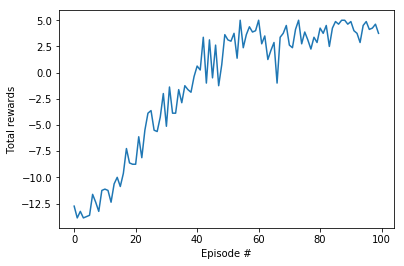

In [6]:
fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.show()

In [31]:
# load the checkpoint
policy.load_state_dict(torch.load('PPO_checkpoint.pth'))
# load to cpu and save the best weights
torch.save(policy.cpu().state_dict(), "pong_PPO.pth")

In [32]:
envs.close()